In [7]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from ultralytics import YOLO
from PIL import Image
import os
import cv2

card_names = ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', 
              '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s',
              '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s',
              '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s',
              '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As',
              'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks',
              'Qc', 'Qd', 'Qh', 'Qs']


In [3]:
def get_free_gpu():
    if not torch.cuda.is_available():
        return torch.device("cpu")

    free_mem = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)
        torch.cuda.empty_cache()
        stats = torch.cuda.mem_get_info(i)
        free_mem.append((stats[0], i))  

    _, best_gpu = max(free_mem)
    return torch.device(f"cuda:{best_gpu}")

device = get_free_gpu()

# Load YOLO
yolo_model = YOLO('/work/csse463/202620/03/runs/detect/train26/weights/best.pt')

# Rebuild CNN architecture 
num_classes = 52  # playing cards
cnn_model = resnet18(weights=None)
cnn_model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
cnn_model.maxpool = nn.Identity()
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, num_classes)
# Load trained weights
cnn_model.load_state_dict(
    torch.load("cnn_resnet18_224x224.pt", map_location=device)
)
cnn_model.to(device)
cnn_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [8]:
# Transform for CNN (must match training)
cnn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def detect_and_classify(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = yolo_model(image_rgb)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    predictions = []

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)

        crop = image_rgb[y1:y2, x1:x2]
        crop_pil = Image.fromarray(crop)
        input_tensor = cnn_transform(crop_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = cnn_model(input_tensor)
            _, pred = torch.max(outputs, 1)

        class_id = pred.item()
        card_label = card_names[class_id]

        predictions.append({
            "box": (x1, y1, x2, y2),
            "class_id": class_id,
            "card": card_label
        })

        # Draw on original image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(image, card_label, (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    return image, predictions




0: 416x416 2 2cs, 2 2ss, 11.6ms
Speed: 12.9ms preprocess, 11.6ms inference, 10.1ms postprocess per image at shape (1, 3, 416, 416)


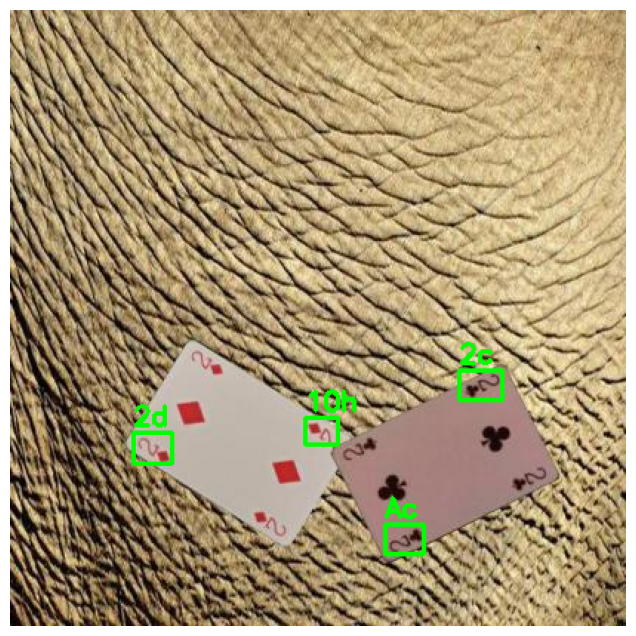

In [10]:
import matplotlib.pyplot as plt

output_image, predictions = detect_and_classify("./test/images/008302373_jpg.rf.8fa0b1f53b2ffccb6108b7ccdc1a45d2.jpg")

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [13]:
from tqdm import tqdm

def evaluate_pipeline(test_root):
    images_path = os.path.join(test_root, "images")
    labels_path = os.path.join(test_root, "labels")

    total_cards = 0
    correct_cards = 0
    missed_detections = 0

    for img_name in tqdm(os.listdir(images_path), disable=True):
        img_path = os.path.join(images_path, img_name)
        label_path = os.path.join(
            labels_path,
            img_name.replace(".jpg", ".txt")
        )

        # --- Get Ground Truth Cards ---
        true_cards = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()
                for line in lines:
                    class_id = int(line.split()[0])
                    true_cards.append(card_names[class_id])

        # --- Run Pipeline ---
        _, predictions = detect_and_classify(img_path)

        predicted_cards = [p["card"] for p in predictions]

        # --- Count ---
        total_cards += len(true_cards)

        # Compare as multisets (handle duplicates properly)
        for card in true_cards:
            if card in predicted_cards:
                correct_cards += 1
                predicted_cards.remove(card)  # prevent double counting
            else:
                missed_detections += 1

    accuracy = correct_cards / total_cards

    print("\n===== Pipeline Results =====")
    print(f"Total Cards: {total_cards}")
    print(f"Correct Cards: {correct_cards}")
    print(f"Missed Cards: {missed_detections}")
    print(f"End-to-End Accuracy: {accuracy:.4f}")

    return accuracy


In [14]:
evaluate_pipeline("./test/")



0: 416x416 2 Kcs, 22.9ms
Speed: 7.8ms preprocess, 22.9ms inference, 10.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 10d, 2 10ss, 1 Qc, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 9.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 Jcs, 1 Jd, 1 Js, 1 Ks, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Js, 1 Qc, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 9.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 4cs, 8.5ms
Speed: 1.5ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 4s, 1 7s, 11.0ms
Speed: 3.1ms preprocess, 11.0ms inference, 9.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 4s, 4 8ss, 9.1ms
Speed: 4.3ms preprocess, 9.1ms inference, 9.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 5c, 1 5s, 2 8ss, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 6.2ms postprocess p

0.4831312598840274